# Introduction to Deep Learning with Keras 2

### 5th Summer School on INtelligent signal processing for FrontIEr Research and Industry, Wuhan, May 2019

will be at dkgithub

### GPU Usage

Before we start, let us check if we have a GPU available. Deep learning needs efficient numerical linear algebra calculations. https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms
They are provided by special libraries (openBLAS, MKL(Intel), cuBLAS(NVidia)).
Graphical processing units (GPU) can be used as accelerators for vector and matrix operations.

Keras/Tensorflow will automatically use an available GPU. Provided that the necessary CUDA libraries from NVidia are available and that the GPU version of Tensorflow is available.  

In [1]:
from tensorflow.python.client import device_lib
import tensorflow as tf
print(tf.__version__)
print(device_lib.list_local_devices())

1.13.1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1269856431992192252
]


Look for the `device_type` and some kind of 'GPU'.
***
Next, we define a function to plot learning curves. We will need this later. Just click the cell and continue to the next part.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
def plotLearningCurves(*histObjs):
    """This function processes all histories given in the tuple.
    Left losses, right accuracies
    """
    # too many plots
    if len(histObjs)>10: 
        print('Too many objects!')
        return
    # missing names
    for histObj in histObjs:
        if not hasattr(histObj, 'name'): histObj.name='?'
    names=[]
    # loss plot
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    # loop through arguments
    for histObj in histObjs:
        plt.plot(histObj.history['loss'])
        names.append('train '+histObj.name)
        plt.plot(histObj.history['val_loss'])
        names.append('test '+histObj.name)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(names, loc='upper right')
    

    #accuracy plot
    plt.subplot(1,2,2)
    for histObj in histObjs:
        plt.plot(histObj.history['acc'])
        plt.plot(histObj.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(names, loc='upper left')
    
    plt.show()
    
    # min, max for loss and acc
    for histObj in histObjs:
        h=histObj.history
        maxIdxTrain = np.argmax(h['acc'])
        maxIdxTest  = np.argmax(h['val_acc'])
        minIdxTrain = np.argmin(h['loss'])
        minIdxTest  = np.argmin(h['val_loss'])
        
        strg='\tTrain: Min loss {:6.3f} at {:3d} --- Max acc {:6.3f} at {:3d} | '+histObj.name
        print(strg.format(h['loss'][minIdxTrain],minIdxTrain,h['acc'][maxIdxTrain],maxIdxTrain))
        strg='\tTest : Min loss {:6.3f} at {:3d} --- Max acc {:6.3f} at {:3d} | '+histObj.name
        print(strg.format(h['val_loss'][minIdxTest],minIdxTest,h['val_acc'][maxIdxTest],maxIdxTest))
        print(len(strg)*'-')


## Classification
In the first tutorial notebook, we used the neural network (NN) as a regression tool. Classification is a second large area where deep neural networks are applied. 
Depending on the different classes we want to distinguish, we talk about

 * Binary classification
 * Multi-class classification

We are still in the field of supervised learning, but the true values are now **discrete class labels**.

In **binary classification** the target values are typically $y^{(i)} \in \{0,1\}$,  like "Cats=0" and "Dogs=1", or Background and Signal. 
The dataset consists in this case of the multi-dimensional input vectors $\mathbf{x}^{(i)}$, our data points, together with the true labels $y^{(i)} \in \{0,1\}$.

In order to make the connection between the discrete class label and the continuous NN output, we introduce a probabilistic interpretation of the NN. We assume that the NN represents some probability density $p(\mathbf{x}|\mathbf{w},\mathbf{b})$, and we try to learn this density from the distribution of the labels in our data. 

A single node as the last layer with a sigmoid activation function, the **logistic function**, is a way to implement this. The logistic function  maps all input values into the range $[0,1]$, as it should be for a proper probability.

<img src="img/Activation_logistic.png" width="200" >$f(x)=\frac{1}{1+\exp({-x})}$  


A special loss function is needed for the training of such a network. 
The optimal parameters $\mathbf{w,b}$ can be found by an Maximum Likelihood approach.
The decision between 1/0 is a binomial process (Bernoulli trial), like tossing a coin. 
If we assume that the NN represents a probability estimate 
$\widehat{y}=p(\mathbf{x}|\mathbf{w},\mathbf{b})$, than the probability for being in class 1 will be just $\widehat{y}$, and $1-\widehat{y}$ for being in class 0. For a batch with $n_{batch}$ data points, we multiply the probability for each data point

$$\prod_\textrm{k in class 1}^{n_{batch}} \widehat{y}_k 
\cdot \prod_\textrm{k in class 0}^{n_{batch}}(1-\widehat{y}_k) 
= \prod_k^{n_{batch}}  [ y_k \widehat{y}_k + (1-y_k)(1-\widehat{y}_k) ], 
$$

and the -log likelihood becomes:
$$-\frac{1}{n_{batch}}\sum_{i=1}^{n_{batch}}y_i\log(\widehat{y_i})+(1-y_i)\log(1-\widehat{y_i})$$ 


 
This expression is also known as **cross entropy**. The name is related to the fact that entropy is defined as the expectation value of log(probability): _Entropy_$\,:=\int log(p)p(x)dx$. If we take the average over some other probability $q(x)$, we talk about cross entropy, _Cross Entropy_$\,:=\int log(p)q(x)dx$. It can be shown that the cross entropy becomes minimal when the two probabilities are identical $p=q$. https://en.wikipedia.org/wiki/Gibbs%27_inequality<br>
In addition, we have normalized by $1/n_{batch}$ that makes it easy to interpret,for example $\frac{1}{n_{batch}}\sum_{i=1}^{n_{batch}}y_i$ as probability for finding class 1 in the batch.

In short, with cross entropy as loss function, the NN learns to model the probability distribution of the training labels $y^{(i)}$ in the data. The output of the NN, the prediction $\widehat{y}$, is a number between [0,1], and by default, a threshold of 0.5 is applied to get a yes/no answer.
***

### Binary Classification Example 

We create the same toy data as in part 1, but this time we only ask if the output is positive.

$$y=
\begin{cases}
    \;1,& \textrm{if }  \sin(\sum_{l=1}^{10} x_l^2) \ge 0 \\
    \;0,& \textrm{otherwise}
\end{cases}
$$

In [3]:
import numpy as np
# We create 10000 random vectors each 10-dim
N_samples=10000
N_in=10
# A matrix N_samplesxN_in, uniform in [0,1)
x_train=np.random.rand(N_samples,N_in)
# Sum of squares along N_in
z = np.sum( np.square(x_train),axis=1)
y_train = (np.sin(z) >= 0).astype(np.int32)

In [4]:
# The first 20 target values. A sequence of 0 and 1
print(y_train[:20])

[1 0 0 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 1]


***
We build a simple network to classify our toy data with 1 hidden layer and logistic function as output. 

In [5]:
from tensorflow.keras import models, layers, losses, optimizers
# To suppress deprecation warnings in some environments
from tensorflow import logging
logging.set_verbosity(logging.ERROR)

model = models.Sequential(
    [
        layers.Dense(100, activation='relu', input_dim=10),
        layers.Dense(100, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)
optimizer = optimizers.Adam()
model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=['acc'])
model.summary()
histObj = model.fit(x_train, y_train, batch_size=256, epochs=25, validation_split=0.2)
#histObj = model.fit(x_train, y_train, batch_size=256, epochs=200, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1100      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 11,301
Trainable params: 11,301
Non-trainable params: 0
_________________________________________________________________
Train on 8000 samples, validate on 2000 samples
Epoch 1/25
8000/8000 [==============================] - 0s 36us/sample - loss: 0.6673 - acc: 0.5535 - val_loss: 0.6543 - val_acc: 0.5585
Epoch 2/25
8000/8000 [==============================] - 0s 9us/sample - loss: 0.6202 - acc: 0.6041 - val_loss: 0.5962 - val_acc: 0.6280
Epoch 3/25
8000/8000 [==============================] - 0s 7us/sample - loss: 0.5

***
 There are a few things to note.
* The shorthand name in Keras for the logistic function is just `sigmoid`.
* Keras provides a cross entropy loss function for the binary case:<br> 
**binary_crossentropy** https://keras.io/backend/#sparse_categorical_crossentropy  https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy.
* When we compile this model, we also add **accuracy** (1) as a **metric**: `metrics=['acc']`.<br>
A metric is an additional quality measure, similar to the loss, but it is not used for the learning. 
* We define a validation sample for the fit method: `validation_split=0.2`. This means that 20% of our training data will be put aside and only be used for **validation** (2), i.e. for calculation the validation loss and validation accuracy. 

(1) Accuracy is calculated from the predictions of the trained network. It is defined as the ratio of the correctly classified labels over all data. 

(2) When we test the performance of a network on the same dataset as used for training, the result will be over-optimistic. The network typically learns some accidental patterns (green line below) from the datasets. The performance will not **generalize** to new, unseen data. To check for such **overfitting** or overtraining, 
<br>
<img src="img/Overfitting_wikipedia.png" width="200" >
https://en.wikipedia.org/wiki/Overfitting<br>
it is mandatory to evaluate the loss and the metric(s) on an **independent test sample** to control the learning process!

In [6]:
# We have now 2x2 histories, 
# for the 2 samples, training and validation,
# and for the loss and the accuracy
histObj.history.keys()

['acc', 'loss', 'val_acc', 'val_loss']

### Learning Curves

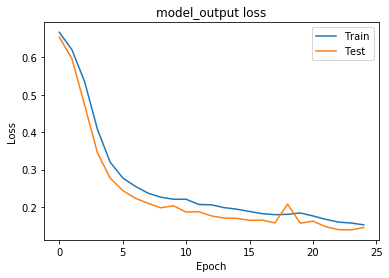

In [7]:
# Plot training & validation loss values over epochs
plt.plot(histObj.history['loss'])
plt.plot(histObj.history['val_loss'])
plt.title('model_output loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Again, the loss drops quickly over the first epochs and then improves only slowly.
Note the peculiarity of the Keras history object: In the first epochs, the test loss is lower than the train loss. We would expect the opposite behavior: a better or at least similar performance on the train data due to overfitting. The reason is that the training loss is computed as the average of the losses over each batch of training data. Because our model is changing with time, the loss over the first batches of an epoch is generally higher than over the last batches. In contrast, the testing loss is only calculated using the model at the end of each epoch, resulting in a lower loss. After some epochs, when the model does not change quickly anymore, and the overtraining becomes larger, we see the expected trend.

The fact that train and test loss do not diverge strongly shows that the chosen model is not too complex for our problem - maybe it is to simple. 

The loss is still falling after 20 epochs. A larger number of epochs will probably improve the training.   Try!

The slowly improving part of the learning curve is the important part for learning subtle features of the data. The stochastic gradient decent learning gets into a more diffusion like phase where the weights only improve slowly, but this is also the phase where severe overtraining may appear. Typically, one stops the training when the loss do not improve within certain limits (**early stopping**).
***
The accuracy in the next plot follows mainly the loss improvement. It starts at about 0.5 - even a purely random label would be correct in 50% of the trials. 

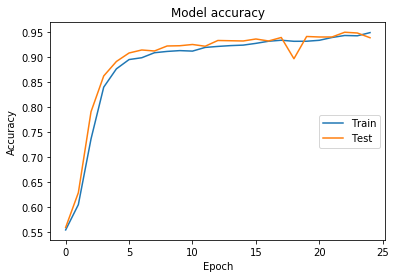

In [8]:
# Plot training & validation accuracy values
plt.plot(histObj.history['acc'])
plt.plot(histObj.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='right')
plt.show()

***
We can evaluate our model on a dataset: `model.evaluate` returns the metric(s) and loss(es) we have provided in the compile step. Note that a larger batch size also speeds up the calculation during prediction.

In [9]:
# We evaluate our model on the complete training dataset 
# A larger batch size speeds up the calculations
loss_value, accuracy = model.evaluate(x_train, y_train,batch_size=512)
print(loss_value,accuracy)

10000/10000 [==============================] - 0s 2us/sample - loss: 0.1533 - acc: 0.9426
(0.15331779980659485, 0.9426)


In [10]:
## Uncomment, if you want to test the speed improvements yourself
#%timeit y_pred=model.predict(x_train).reshape(y_train.shape) 
# 1 loop, best of 3: 189 ms per loop - Intel Core i7 2 core 2.5 GHz MacBook Pro
#%timeit y_pred=model.predict(x_train,batch_size=512).reshape(y_train.shape)
# 10 loops, best of 3: 17 ms per loop
## The results maybe differ but only within the numerical precision
#y_pred_a=model.predict(x_train).reshape(y_train.shape)
#y_pred_b=model.predict(x_train,batch_size=512).reshape(y_train.shape)
#print('numeric identical',np.sum(np.isclose(y_pred_a,y_pred_b)))
y_pred=model.predict(x_train,batch_size=512).reshape(y_train.shape)

In [11]:
# The accuracy calculation by hand
accuracy=np.mean(np.equal(y_train, y_pred>0.5))
print(accuracy)

0.9426


***
## Multi-Class Classification 

Often a problem consists in identifying multiple classes or categories. Each data point belongs to exactly one class, and the training data is labeled according to the $K$ classes: $y^{(i)}\in\{1,..,K\}$. The classical example is the identification of images from handwritten numbers 0-9 (the MNIST dataset). https://deepai.org/machine-learning-glossary-and-terms/mnist-database

The considerations presented above for binary classification can be applied in a similar way to multi-class classification.
Instead of a binomial problem, we have now a multi-nomial problem, and the proper loss function becomes the **categorical cross entropy**.

As in the binary case, we implement a probability interpretation of the NN output. The output layer must be extended to represent the $K$ classes. Instead of the one sigmoid, we must have $K$ nodes with output $z_k$, and we need an activation function that allows a probability interpretation. The appropriate activation function in this case is called **softmax**:

$f_{k}(\overrightarrow{z})=\frac{\exp({z_{k}})}{\sum_{m=1}^{K} \exp({z_{m}})} \quad \text { for } k=1, \ldots, K$ https://en.wikipedia.org/wiki/Softmax_function

The softmax function is defined in a way that each output node stays within $[0,1]$, as it must be for a probability, and the sum of all outputs is always one ($\sum_k f_k=1$) since by definition each data point must belong to one class. The predicted class is then the node with the largest softmax output.

In short, for multi-classification we use $K$ nodes with softmax activation and (sparse, see below) categorical cross entropy as loss.



###  Fashion-MNIST

As multi-class example, we take the Fashion-MNIST dataset. This dataset had been become popular in last few years as a benchmark example in image classification. https://github.com/zalandoresearch/fashion-mnist
(Zalando SE is a European e-commerce company based in Berlin selling fashion products.)

Keras knows this dataset and can provides the images (or downloads them on first use).

In [12]:
#import tensorflow as tf
#dataset = tf.keras.datasets.fashion_mnist
#(x_train, y_train),(x_test, y_test) = dataset.load_data()

In [13]:
#--- by technical reasons we load the data locally
import gzip
import numpy as np
with gzip.open('./fashion-mnist/train-labels-idx1-ubyte.gz', 'rb') as bits:
    y_train = np.frombuffer(bits.read(), np.uint8, offset=8)
with gzip.open('./fashion-mnist/t10k-labels-idx1-ubyte.gz', 'rb') as bits:
    y_test  = np.frombuffer(bits.read(), np.uint8, offset=8)
with gzip.open('./fashion-mnist/train-images-idx3-ubyte.gz', 'rb') as bits:
    x_train = np.frombuffer(bits.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28)
with gzip.open('./fashion-mnist/t10k-images-idx3-ubyte.gz', 'rb') as bits:
    x_test = np.frombuffer(bits.read(), np.uint8, offset=16).reshape(len(y_test), 28, 28)

The dataset consists of 60k training images and 10k test images. The images are grayscale (0-255 integer) with 28x28 pixels. There are 10 equal sized categories. 

In [14]:
print(x_train.shape)
print(x_train.dtype)

(60000, 28, 28)
uint8


In [15]:
# It is always a good practice to normalize the dataset.
x_train, x_test = x_train / 255.0, x_test / 255.0
print(x_train.dtype) # float32 has an higher efficiency on GPUs - float64 with a CPU

float64


We print the first 20 labels from this dataset.

In [16]:
print(y_train[:20])

[9 0 0 3 0 2 7 2 5 5 0 9 5 5 7 9 1 0 6 4]


A technicality, Keras provides two versions of categorical cross entropy (CCE) loss. The choice depends on the way how the class labels are represented. There are essentially 2 possibilities: the one-hot-encoding, for example `[0,0,0,1,0,0,0,0,0,0]`, where the position marks the class, or just integer numbers, like '3'. From the previous cell, we see that the latter is used in the fashion-MNIST dataset. The appropriate implementation of the loss function in this case is the sparse CCE.
***
We define names for the classes, and plot a few training images to get an idea of the data.

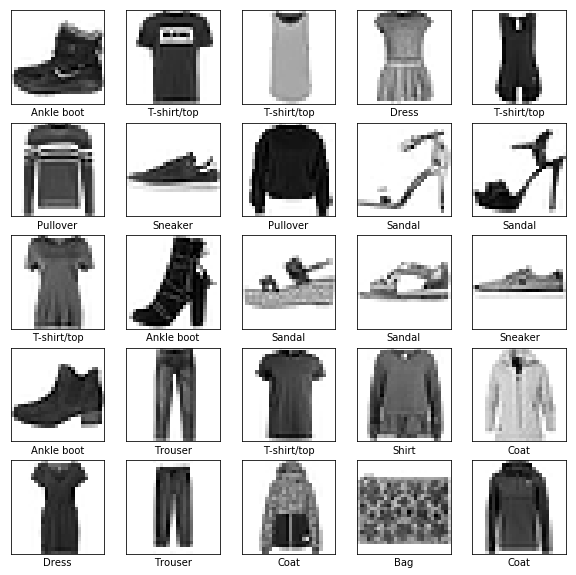

In [17]:
class_names=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])

Indeed, fashion items in low res.

### Building the Network

A dense network with 2 hidden layers. The aim is to identify from the picture the class it belongs to.
* As in the introduction described, we use a last layer with $K=10\,$ nodes and the 'softmax' activation together with sparse categorical cross entropy.
* The first layer flattens the images. The 28x28 image is transformed into a 784 vector. There are better ways to handle image data, e.g. (see below) convolution.
* Accuracy as metric is included. There are now 10 categories and a randomly applied label would have a 10% chance to be correct. 
* Note that with a few lines of code we have defined a model with more than half a million of parameters.
* For validation, we use now the separate test dataset in the fit() method:`validation_data=(x_test,y_test)`.

In [18]:
from tensorflow.keras import models, layers, losses, optimizers

model1 = tf.keras.models.Sequential([
  layers.Flatten(input_shape=(28, 28)),
  layers.Dense(512, activation='relu'),
  layers.Dense(512, activation='relu'),
  layers.Dense(10, activation='softmax')
])
model1.summary()

model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
histObj1 = model1.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size=256, epochs=15)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 4s 60us/sample - loss: 0.5086 - acc: 0.8189 - val_loss: 0.4069 - val_acc: 0.8558
Epoch 2/15
60000/60000 [==============================] - 3s 58us/sample - loss

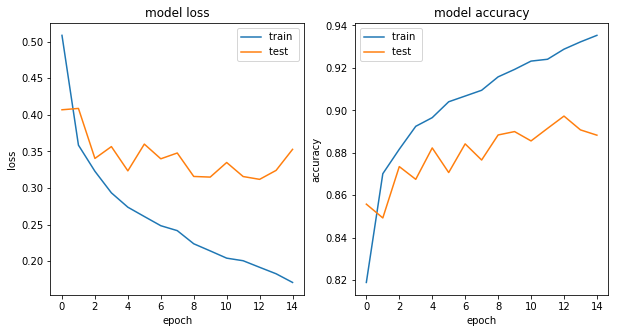

	Train: Min loss  0.171 at  14 --- Max acc  0.935 at  14 | 
	Test : Min loss  0.312 at  12 --- Max acc  0.897 at  12 | 
-----------------------------------------------------------------


In [19]:
histObj1.name='' # name added to legend
plotLearningCurves(histObj1) # the above defined function to plot learning curves

Again, the loss drops quickly over the first epochs and then improves only slowly. But this time, the **gap between test and train** is significant, and the loss on test data does not much improve, whereas the train loss continues to fall. We create overtraining. The accuracy on the test data is significantly smaller, the model does not generalize well.

In [20]:
# we calculate accuracy and loss on the trained model for the both samples
loss_train, acc_train = model1.evaluate(x_train, y_train,batch_size=512)
loss_test, acc_test   = model1.evaluate(x_test, y_test,batch_size=512)
print("Training data loss %6.4f, acc %6.4f" % (loss_train,acc_train))
print("Test data loss     %6.4f, acc %6.4f" % (loss_test,acc_test))

10000/10000 [==============================] - 0s 18us/sample - loss: 0.3528 - acc: 0.8883
Training data loss 0.1682, acc 0.9364
Test data loss     0.3528, acc 0.8883


The human accuracy in this task is about 0.835. The most sophisticated algorithms push it up to 0.96.
***
Our predictions looks like this:

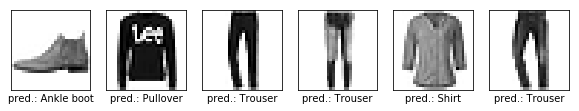

In [21]:
# the 5 first test images
import numpy as np
sixImages = x_test[0:6]
predictions = model1.predict(sixImages)
predictions = np.argmax(predictions,axis=1)

plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sixImages[i], cmap=plt.cm.binary)
    plt.xlabel('pred.: '+class_names[predictions[i]])
plt.show()

### Methods to prevent overtraining

Overfitting is related to the complexity of the model in relation to the available data. We have 669706 parameters. A model with many parameters will be able to "memorize" the training data. Reducing the complexity of the model will improve the generalization ability. On the other hand, reducing the complexity of the model will reduce its predictive power. It is up to the model designer (you!) to find a good compromise, and there is no general applicable recipe for this task.

You will have to experiment with the parameters of the network. The number of layers, the size of the layers, as well as the learning rate, the batch size etc. 

A possible strategy is to increase the complexity of the model until at least the training accuracy is on a sufficient level and then introduce **regularization** to the network. Regularization means that the loss is modified in a way to improve some aspect of the performance of a model.
https://en.wikipedia.org/wiki/Regularization_(mathematics) For example, in "weight regularization" a cost related to the size of the weights is added.

Keras provides several methods to make the network more robust.

* Weight regularization https://keras.io/regularizers/
* Batch normalization https://keras.io/layers/normalization/#batchnormalization
* Dropout https://keras.io/layers/core/#dropout

**Weight regularization** Even if we have sufficient data, the weights in a network may not be constraint. Consider two consecutive layers. The weights in the first layer may grow steadily and shrink in the second layer such that the total effect stays constant. Adding a penalty, e.g. the sum of the squares of the layer weights `l2`,to the loss helps to control the size of the weights .

**Batch normalization** is similar to normalizing the input data but applied between the layers and for each batch. It normalizes the activations of the previous layer at each batch, i.e. transforms mean to 0 and standard deviation to 1.

**Dropout** is the idea to remove nodes from a layer during training randomly at typical rate of $p=0.2-0.3$. From iteration to iteration suddenly a node may disappear. 

Play!

* Reduce the 2 hidden layers to 256 and 128. The performance degrades (worse validation accuracy), but the gap between training and test results becomes smaller (less overfitting).
* Go back to the 2 hidden 512 layers and introduce weight regularization<br>
(... `kernel_regularizer=regularizers.l2(0.0001)` ...)<br> 
to the first hidden layer. The train-test gap should shrink, but probably also the best accuracy.
* Go back to the 2 hidden 512 layers and include batch normalization (`layers.BatchNormalization()`) after the first hidden layer. Again, the train-test gap should shrink, but probably also the best accuracy.
* Go back to the 2 hidden 512 layers and include a dropout layer (`layers.Dropout(rate=0.2)`) after the first hidden layer. The gap between test and train will become smaller but hopefully the performance stays good. Dropout regularizes the growth of the weights, too. If this performs reasonably, a few more epochs (50) may improve the model such that we touch the 90% accuracy.

In [22]:
from tensorflow.keras import models, layers, losses, optimizers, regularizers

model2 = tf.keras.models.Sequential([
  layers.Flatten(input_shape=(28, 28)),
  layers.Dense(256, activation='relu'),
#  layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.0001)),
#  layers.Dense(512, activation='relu'),
#  layers.BatchNormalization(),
#  layers.Dropout(rate=0.3),
#-------
layers.Dense(128, activation='relu'),
#  layers.Dense(512, activation='relu'),
  layers.Dense(10, activation='softmax')
])
model2.summary()

model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

histObj2 = model2.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size=256, epochs=15)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 2s 30us/sample - loss: 0.5432 - acc: 0.8116 - val_loss: 0.4481 - val_acc: 0.8421
Epoch 2/15
60000/60000 [==============================] - 1s 25us/sample - loss

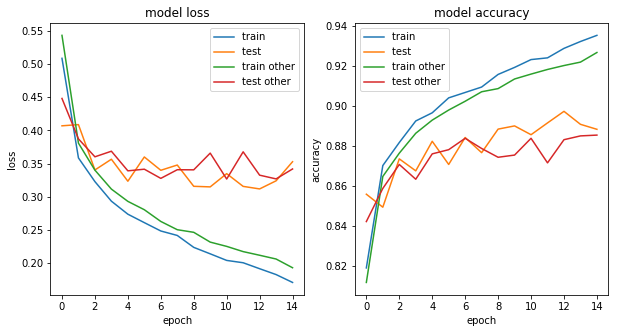

	Train: Min loss  0.171 at  14 --- Max acc  0.935 at  14 | 
	Test : Min loss  0.312 at  12 --- Max acc  0.897 at  12 | 
-----------------------------------------------------------------
	Train: Min loss  0.193 at  14 --- Max acc  0.927 at  14 | other
	Test : Min loss  0.327 at  10 --- Max acc  0.885 at  14 | other
----------------------------------------------------------------------


In [23]:
histObj1.name=''
histObj2.name='other' # put a useful name
plotLearningCurves(histObj1,histObj2)

## Closing Remarks

* We missed the most important element for image classification: **convolutional neural networks** (CNNs). https://towardsdatascience.com/convolutional-neural-networks-for-beginners-practical-guide-with-python-and-keras-dc688ea90dca
* Keras allows to define **callbacks** in the fit method to perform many useful tasks during the training, e.g. at the begin or end of each epoch. https://keras.io/callbacks/
* We did not discuss the way the initial weights are initialized. https://keras.io/initializers/ 
* And many more things. https://keras.io/getting-started/sequential-model-guide/#examples